In [ ]:
import MDAnalysis as mda
import time
import os
import numpy
from multiprocessing import Pool
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import vesicle_analysis_methods as vam
%matplotlib inline
print("MDA version: " + mda.__version__)

# Spuddafett Performance

In [ ]:
hostname = "spuddafett"
fig_dir = "/nfs/homes/ikenney/Projects/vesicles/scripts/analysis/figs/"
data_dir = "/nfs/homes/ikenney/Projects/vesicles/scripts/analysis/data/"
systems_dir = "/nfs/homes/ikenney/Projects/vesicles/scripts/analysis/systems/"

values = [y.split('/')[-1] for y in glob.glob("systems/*")]

def fig_save(inputs):
    paths = [fig_dir+inputs.replace(" ","_").lower()+".png",fig_dir+inputs.replace(" ","_").lower()+".pdf"]
    for p in paths:
        plt.savefig(p)
        
if os.path.exists(data_dir+"performance_combined.df"):
    systems = pd.read_pickle(data_dir+"performance_combined.df")
    print("Pickle loaded")
else:
    systems = pd.DataFrame(index=values+['1_5M','3M'])
    location = '/nfs/homes/ikenney/Projects/vesicles/vesicle_library/lib/{}/'.format('rad_gpu')
    pd.DataFrame()
    tops = list((location+'%s/nvt/nvt.tpr') % v for v in values)
    traj = list((location+'%s/nvt/analysis.xtc') % v for v in values)
    gros = list((location+'%s/emin/emin.gro') % v for v in values)
    pdbs = list((location+'%s/emin/emin.pdb') % v for v in values)
    systems['tops'] = list((location+'%s/nvt/nvt.tpr') % v for v in systems.index.tolist())
    systems['traj'] = list((location+'%s/nvt/nvt.xtc') % v for v in systems.index.tolist())
    systems['gros'] = list((location+'%s/emin/emin.gro') % v for v in systems.index.tolist())
    systems['pdbs'] = list((location+'%s/emin/emin.pdb') % v for v in systems.index.tolist())
    systems['sizes'] = list(mda.Universe((location+'%s/emin/emin.tpr') % v).atoms.n_atoms for v in systems.index.tolist())
    print("Pickle not loaded. Creating new dataframe")
    systems.to_pickle("performance_combined.df")

In [ ]:
testing = vam.integrity(pd.DataFrame(columns=systems.columns.tolist()),N=3)

In [ ]:
testing = pd.read_pickle("backup.df")

In [ ]:
testing = vam.integrity(testing,N=3)

In [ ]:
testing

## Radius of Gyration

In [ ]:
def performance(a):
    u = mda.Universe(a[0],a[1])
    vals = []
    for frame in u.trajectory:
        start = time.time()
        u.atoms.radiusOfGyration()
        vals.append(time.time()-start)
    return vals

Record times to perform radius of gyration calculations on each data set

In [ ]:
p = Pool(len(values))
processlist = list([systems['tops'][x],systems['traj'][x],systems['sizes'][x]] for x in range(len(systems)))
data = p.map(performance,processlist)
systems['rgyr'] = data
p.close()
timedata = np.array([[np.mean(x),np.std(x)] for x in data])
systems['rgyr_mean'] = list(np.mean(r) for r in systems['rgyr'])
systems['rgyr_std'] = list(np.std(r) for r in systems['rgyr'])
systems.to_pickle("performance_combined.df")

In [ ]:
#plt.figure(figsize=(8,4))
plt.title("Radius of Gyration Performance on {}".format(hostname))
plt.xlabel("System Size (atoms)")
plt.ylabel("Calculation time (s)")
plt.errorbar(systems['sizes'],systems['rgyr_mean'],yerr=systems['rgyr_std'])
#plt.savefig("/nfs/homes/ikenney/report/figs/geometric/calc_time_vs_system.png")
#plt.savefig("/nfs/homes/ikenney/report/figs/geometric/calc_time_vs_system.pdf")

## Load Times

Record times for loading universes with different schemes

### TPR and XTC

In [ ]:
N = 40
def performanceload(a):
    res = a[3]
    def load():
        start = time.time()
        u = mda.Universe(a[0],a[1])
        return time.time() - start
    return [load() for _ in range(res)]

In [ ]:
N = 40
p = Pool(len(values))
processlist = list([systems['tops'][x],systems['traj'][x],systems['sizes'],N] for x in range(len(systems.index.tolist())))
dataload = p.map(performanceload,processlist)
systems['load_tpr_xtc'] = dataload
p.close()
systems['load_tpr_xtc_mean'] = list(np.mean(r) for r in systems['load_tpr_xtc'])
systems['load_tpr_xtc_std'] = list(np.std(r) for r in systems['load_tpr_xtc'])
systems.to_pickle("performance_combined.df")

In [ ]:
systems.to_pickle("performance_combined.df")

In [ ]:
systems['load_tpr_xtc_median'] = list(np.median(r) for r in systems['load_tpr_xtc'])

In [ ]:
N = 40
inputs = "TPR and XTC"
#plt.figure(figsize=(8,4))
plt.title("Load Time Performance on {0} loading {1} ({2} runs)".format(hostname,inputs,N))
plt.xlabel("System Size (atoms)")
plt.ylabel("Load time (s)")
A = plt.errorbar(systems['sizes'],systems['load_tpr_xtc_mean'],yerr=systems['load_tpr_xtc_std'])
fig_save(inputs)

### GRO only

In [ ]:
N = 40
def performanceload(a):
    res = a[2]
    def load():
        start = time.time()
        u = mda.Universe(a[0])
        return time.time() - start
    return [load() for _ in range(res)]

In [ ]:
p = Pool(len(values))
processlist = list([systems['gros'][x],systems['sizes'][x],N] for x in range(len(systems)))
dataload = p.map(performanceload,processlist) 
systems['load_gro'] = dataload
p.close()
systems['load_gro_mean'] = list(np.mean(r) for r in systems['load_gro'])
systems['load_gro_std'] = list(np.std(r) for r in systems['load_gro'])
systems.to_pickle("performance_combined.df")

In [ ]:
inputs = "GRO"
#plt.figure(figsize=(8,4))
plt.title("Load Time Performance on {0} loading {1} ({2} runs)".format(hostname,inputs,N))
plt.xlabel("System Size (atoms)")
plt.ylabel("Load time (s)")
B = plt.errorbar(systems['sizes'],systems['load_gro_mean'],yerr=systems['load_gro_std'])
#plt.savefig("/nfs/homes/ikenney/report/figs/loading/"+inputs.replace(" ","_").lower())
#plt.savefig("/nfs/homes/ikenney/report/figs/loading/"+inputs.replace(" ","_").lower()+".pdf")

## PDB only

In [ ]:
N = 40
def performanceload(a):
    res = a[2]
    def load():
        start = time.time()
        u = mda.Universe(a[0])
        return time.time() - start
    return [load() for _ in range(res)]

In [ ]:
p = Pool(len(values))
processlist = list([systems['pdbs'][x],systems['sizes'][x],N] for x in range(len(systems)))
dataload = p.map(performanceload,processlist)   
systems["load_pdb"] = dataload
p.close()
systems['load_pdb_mean'] = list(np.mean(r) for r in systems['load_pdb'])
systems['load_pdb_std'] = list(np.std(r) for r in systems['load_pdb'])
systems.to_pickle("performance_combined.df")

In [ ]:
inputs = "PDB"
#plt.figure(figsize=(8,4))
plt.title("Load Time Performance on {0} loading {1} ({2} runs)".format(hostname,inputs,N))
plt.xlabel("System Size (atoms)")
plt.ylabel("Load time (s)")
C = plt.errorbar(systems['sizes'],systems['load_pdb_mean'],yerr=systems['load_pdb_std'])
#plt.savefig("/nfs/homes/ikenney/report/figs/loading/"+inputs.replace(" ","_").lower())
#plt.savefig("/nfs/homes/ikenney/report/figs/loading/"+inputs.replace(" ","_").lower()+".pdf")

## GRO and XTC

In [ ]:
def performanceload(a):
    res = a[3]
    def load():
        start = time.time()
        u = mda.Universe(a[0],a[1])
        return time.time() - start
    return [load() for _ in range(res)]

In [ ]:
N = 40
p = Pool(len(values))
processlist = list([systems['gros'][x],systems['traj'][x],systems['sizes'][x],N] for x in range(len(systems)))
dataload = p.map(performanceload,processlist)    
systems['load_gro_xtc'] = dataload
p.close()
systems['load_gro_xtc_mean'] = list(np.mean(r) for r in systems['load_gro_xtc'])
systems['load_gro_xtc_std'] = list(np.std(r) for r in systems['load_gro_xtc'])
systems.to_pickle("performance_combined.df")

In [ ]:
inputs = "GRO and XTC"
#plt.figure(figsize=(8,4))
plt.title("Load Time Performance on {0} loading {1} ({2} runs)".format(hostname,inputs,N))
plt.xlabel("System Size (atoms)")
plt.ylabel("Load time (s)")
D = plt.errorbar(systems['sizes'],systems['load_gro_xtc_mean'],yerr=systems['load_gro_xtc_std'])
#plt.savefig("/nfs/homes/ikenney/report/figs/loading/"+inputs.replace(" ","_").lower())
#plt.savefig("/nfs/homes/ikenney/report/figs/loading/"+inputs.replace(" ","_").lower()+".pdf")

### PDB and XTC

In [ ]:
def performanceload(a):
    res = a[3]
    def load():
        start = time.time()
        u = mda.Universe(a[0],a[1])
        return time.time() - start
    return [load() for _ in range(res)]

In [ ]:
N = 40
p = Pool(len(values))
processlist = list([systems['gros'][x],systems['traj'][x],systems['sizes'][x],N] for x in range(len(systems)))
dataload = p.map(performanceload,processlist)    
systems['load_pdb_xtc'] = dataload
p.close()
systems['load_pdb_xtc_mean'] = list(np.mean(r) for r in systems['load_pdb_xtc'])
systems['load_pdb_xtc_std'] = list(np.std(r) for r in systems['load_pdb_xtc'])
systems.to_pickle("performance_combined.df")

In [ ]:
inputs = "PDB and XTC"
#plt.figure(figsize=(8,4))
plt.title("Load Time Performance on {0} loading {1} ({2} runs)".format(hostname,inputs,N))
plt.xlabel("System Size (atoms)")
plt.ylabel("Load time (s)")
E = plt.errorbar(systems['sizes'],systems['load_pdb_xtc_mean'],yerr=systems['load_pdb_xtc_std'])
#plt.savefig("/nfs/homes/ikenney/report/figs/loading/"+inputs.replace(" ","_").lower())
#plt.savefig("/nfs/homes/ikenney/report/figs/loading/"+inputs.replace(" ","_").lower()+".pdf")

In [ ]:
plt.title("Load Time Performance on spuddafett (40 runs)")
plt.ylabel("Load Time (s)")
plt.xlabel("System Size (atoms)")
plots = [plt.errorbar(systems['sizes'],systems['load_tpr_xtc_mean'],yerr=systems['load_tpr_xtc_std']),plt.errorbar(systems['sizes'],systems['load_gro_mean'],yerr=systems['load_gro_std']),plt.errorbar(systems['sizes'],systems['load_pdb_mean'],yerr=systems['load_pdb_std']),plt.errorbar(systems['sizes'],systems['load_gro_xtc_mean'],yerr=systems['load_gro_xtc_std']),plt.errorbar(systems['sizes'],systems['load_pdb_xtc_mean'],yerr=systems['load_pdb_xtc_std'])]
plt.legend(plots,["TPR,XTC","GRO","PDB","GRO,XTC","PDB,XTC"],loc='best')
#plt.savefig("/nfs/homes/ikenney/report/figs/loading/combined_load")
#plt.savefig("/nfs/homes/ikenney/report/figs/loading/combined_load.pdf")

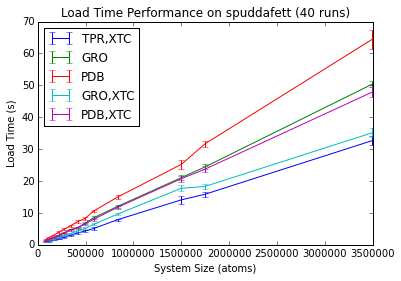

In [5]:
systems = newdata
plt.title("Load Time Performance on spuddafett (40 runs)")
plt.ylabel("Load Time (s)")
plt.xlabel("System Size (atoms)")
plots = [plt.errorbar(systems['sizes'],systems['load_tpr_xtc_mean'],yerr=systems['load_tpr_xtc_std']),plt.errorbar(systems['sizes'],systems['load_gro_mean'],yerr=systems['load_gro_std']),plt.errorbar(systems['sizes'],systems['load_pdb_mean'],yerr=systems['load_pdb_std']),plt.errorbar(systems['sizes'],systems['load_gro_xtc_mean'],yerr=systems['load_gro_xtc_std']),plt.errorbar(systems['sizes'],systems['load_pdb_xtc_mean'],yerr=systems['load_pdb_xtc_std'])]
plt.legend(plots,["TPR,XTC","GRO","PDB","GRO,XTC","PDB,XTC"],loc='best')
#plt.savefig("/nfs/homes/ikenney/report/figs/loading/combined_load")
#plt.savefig("/nfs/homes/ikenney/report/figs/loading/combined_load.pdf")

In [ ]:
systems.drop(systems.index[10])

In [ ]:
testing.drop(testing.index[-1])

In [ ]:
pd.DataFrame(columns=testing.columns.tolist())

In [ ]:
testing

In [ ]:
testing

In [ ]:
testing.to_pickle("backup.df")

In [ ]:
testing

In [ ]:
testing["pdbs"].notnull().loc["30"]

In [ ]:
vam.function_dict

In [ ]:
testing

In [ ]:
import vesicle_analysis_methods as vam
import pandas as pd

#testing = pd.read_pickle("backup.df")
#testing = vam.integrity(testing,N=3)

In [ ]:
newdata = vam.integrity(newdata)

In [ ]:
newdata.to_pickle("newdata.df")

In [ ]:
newdata = pd.read_pickle("newdata.df")

In [ ]:
newdata.loc["3M"]

In [ ]:
vam.integrity(newdata,N=3)

In [1]:
import MDAnalysis as mda
import time
import os
import numpy
from multiprocessing import Pool
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import vesicle_analysis_methods as vam
%matplotlib inline
print("MDA version: " + mda.__version__)
newdata = pd.read_pickle("newdata.df")
newdata = vam.integrity(newdata)

MDA version: 0.11.0
load_tpr_xtc missing from 3M. Fill in data? (y/n)
Fill:	y
['3M', 'load_tpr_xtc']
Added to fill list.

load_gro_xtc missing from 3M. Fill in data? (y/n)
Fill:	y
['3M', 'load_gro_xtc']
Added to fill list.

load_pdb_xtc missing from 3M. Fill in data? (y/n)
Fill:	y
['3M', 'load_pdb_xtc']
Added to fill list.

Filling in data from: /nfs/homes/ikenney/Projects/vesicles/scripts/analysis/systems/3M
checking resources
Adding trajectory information
Filling in data from: /nfs/homes/ikenney/Projects/vesicles/scripts/analysis/systems/3M
checking resources
Filling in data from: /nfs/homes/ikenney/Projects/vesicles/scripts/analysis/systems/3M
checking resources


/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [ ]:
newdata = vam.integrity(newdata,N=3)

In [2]:
newdata

,tops,traj,gros,pdbs,sizes,load_tpr_xtc,load_tpr_xtc_mean,load_tpr_xtc_std,rgyr,rgyr_mean,...,load_gro_std,load_pdb,load_pdb_mean,load_pdb_std,load_gro_xtc,load_gro_xtc_mean,load_gro_xtc_std,load_pdb_xtc,load_pdb_xtc_mean,load_pdb_xtc_std
10,/nfs/homes/ikenney/Projects/vesicles/scripts/a...,/nfs/homes/ikenney/Projects/vesicles/scripts/a...,/nfs/homes/ikenney/Projects/vesicles/scripts/a...,/nfs/homes/ikenney/Projects/vesicles/scripts/a...,84192,"[0.680706977844, 0.760932922363, 0.82935786247...",0.7722436,0.04086874,NaN,NaN,...,0.0967985,"[1.68877291679, 1.79339694977, 1.75952792168, ...",1.699505,0.05264341,"[0.917989969254, 0.931171894073, 0.88675713539...",0.9193079,0.03335214,"[1.12179684639, 1.23192596436, 1.31319212914, ...",1.279128,0.05043979
12.5,/nfs/homes/ikenney/Projects/vesicles/scripts/a...,/nfs/homes/ikenney/Projects/vesicles/scripts/a...,/nfs/homes/ikenney/Projects/vesicles/scripts/a...,/nfs/homes/ikenney/Projects/vesicles/scripts/a...,122208,"[0.891258001328, 1.04460477829, 1.01538491249,...",1.057474,0.07671819,NaN,NaN,...,0.1191053,"[2.27990412712, 2.30675578117, 2.36117100716, ...",2.353735,0.097989,"[1.16333889961, 1.22147083282, 1.22417187691, ...",1.252071,0.06541449,"[1.72504496574, 1.5486061573, 1.61223983765, 1...",1.7398,0.08016933
15,/nfs/homes/ikenney/Projects/vesicles/scripts/a...,/nfs/homes/ikenney/Projects/vesicles/scripts/a...,/nfs/homes/ikenney/Projects/vesicles/scripts/a...,/nfs/homes/ikenney/Projects/vesicles/scripts/a...,167352,"[1.52840089798, 1.53512191772, 1.54856395721, ...",1.44739,0.07513938,NaN,NaN,...,0.117943,"[2.94634389877, 3.06615591049, 2.95870995522, ...",3.0341,0.1417055,"[1.69369387627, 1.65161800385, 1.47233390808, ...",1.717159,0.08936595,"[2.14778995514, 2.56267595291, 2.36677098274, ...",2.272991,0.1242406
17.5,/nfs/homes/ikenney/Projects/vesicles/scripts/a...,/nfs/homes/ikenney/Projects/vesicles/scripts/a...,/nfs/homes/ikenney/Projects/vesicles/scripts/a...,/nfs/homes/ikenney/Projects/vesicles/scripts/a...,219000,"[1.83228397369, 1.88783597946, 1.99191689491, ...",1.865459,0.1060598,NaN,NaN,...,0.1922817,"[4.23802304268, 4.23769903183, 4.01515221596, ...",3.968961,0.2453085,"[2.07118606567, 2.10249185562, 2.33951711655, ...",2.286091,0.1359575,"[3.09319400787, 3.18711495399, 2.98173618317, ...",2.999742,0.1597122
20,/nfs/homes/ikenney/Projects/vesicles/scripts/a...,/nfs/homes/ikenney/Projects/vesicles/scripts/a...,/nfs/homes/ikenney/Projects/vesicles/scripts/a...,/nfs/homes/ikenney/Projects/vesicles/scripts/a...,277728,"[2.28062582016, 2.27865791321, 2.27461481094, ...",2.427777,0.165314,NaN,NaN,...,0.2245936,"[4.79326486588, 4.63493013382, 4.77587509155, ...",4.950939,0.2631853,"[2.76664614677, 3.06926584244, 2.92778778076, ...",2.825868,0.1574814,"[3.51713299751, 3.522356987, 3.36134314537, 3....",3.661395,0.1824004
22.5,/nfs/homes/ikenney/Projects/vesicles/scripts/a...,/nfs/homes/ikenney/Projects/vesicles/scripts/a...,/nfs/homes/ikenney/Projects/vesicles/scripts/a...,/nfs/homes/ikenney/Projects/vesicles/scripts/a...,343500,"[2.87668991089, 2.97341012955, 2.96857309341, ...",2.988239,0.1719281,NaN,NaN,...,0.2618722,"[5.38981699944, 6.61877608299, 6.32967591286, ...",5.983101,0.300066,"[3.53340387344, 3.79097795486, 3.44709300995, ...",3.541951,0.2158795,"[4.93351101875, 4.91674995422, 4.45620107651, ...",4.57652,0.2749574
25,/nfs/homes/ikenney/Projects/vesicles/scripts/a...,/nfs/homes/ikenney/Projects/vesicles/scripts/a...,/nfs/homes/ikenney/Projects/vesicles/scripts/a...,/nfs/homes/ikenney/Projects/vesicles/scripts/a...,416208,"[3.2885799408, 3.32700014114, 3.90747094154, 4...",3.686775,0.1880814,NaN,NaN,...,0.2354892,"[7.85491609573, 7.64530110359, 8.13620305061, ...",7.274715,0.4350955,"[4.09495210648, 3.92461419106, 4.27332901955, ...",4.329834,0.2583628,"[4.98082590103, 5.45941090584, 5.15562486649, ...",5.404492,0.3220006
27.5,/nfs/homes/ikenney/Projects/vesicles/scripts/a...,/nfs/homes/ikenney/Projects/vesicles/scripts/a...,/nfs/homes/ikenney/Projects/vesicles/s